<a href="https://colab.research.google.com/github/abyanjan/Natural-language-Processing-NLP-/blob/master/Text_classification_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji

     |████████████████████████████████| 133kB 5.7MB/s 


**Dowloading data from kaggle**

In [2]:
!pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [6]:
! kaggle competitions download -c 'nlp-getting-started'

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 66.0MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.5MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.2MB/s]


## Data Processing

In [7]:
# Read data
import pandas as pd
import numpy as np

In [8]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# taking only the required columns
train_df = train_df[['text','target']]

In [10]:
print(f'Number of samples: {train_df.shape[0]}')

Number of samples: 7613


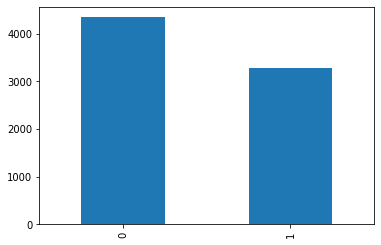

In [11]:
# Target Distribution
import matplotlib.pyplot as plt

train_df.target.value_counts().plot(kind ='bar')
#plt.bar()

**Checking for any duplicates in the text**

In [12]:
train_df['text'].duplicated().sum()

110

In [13]:
# dropping the dupicated texts
train_df = train_df.drop_duplicates('text', keep='last')

**Checking for any Null values**

In [14]:
print(f"Number of Null Values: {train_df['text'].isnull().sum()}")

Number of Null Values: 0


### Cleaning the Text

In [15]:
# checking few of the texts
np.random.seed(123)
for i in np.random.randint(0, len(train_df), 10):
  print(train_df['text'][i], '\n')

APD investigating fatal shooting of 3 year old child in southeast Anchorage http://t.co/qYccvUubkr 

holy crap @KingMyth1999 my phone just exploded. haha 

I will never support looting or the burning of buildings but when seeing the people fight back against the police. I was proud 

#HeartDisease U.S. Forest Service says spending more than half of budget on fires http://t.co/KzfiGkEeva 

I need an arcade shooter fix but CTE is empty &amp; only running obliteration. I'd even buy a CoD title if they weren't all overpriced on steam 

Long Road To Ruin - Foo Fighters 

FUCK NUCLEAR WEAPON 

#NowPlaying Last Smoke Before The Snowstorm by Benjamin Francis Leftwich - hopefully new album coming soon :) ? http://t.co/5kjy8G0i4y 

California oil spill might be larger than projected: http://t.co/xwxBYHTuzC http://t.co/wzeDxEFBlg 

'I'm there!' Bride &amp; Groom on mountain cliff edge. Ha Ha just kidding. I WILL NOT EVER be there. Ha Ha - http://t.co/Io9ry1akON 



In [16]:
import re
import emoji
import nltk

In [17]:
# defining function to clean the text

def clean_text(text):
  text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove urls
  text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
  text = text.replace("#", "") #Remove hashtag sign 
  #text = ''.join(w for w in text if w not in emoji.UNICODE_EMOJI) # remove emojis
  text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # remove any punctuations and convert to lower case
  text = re.sub(' +', ' ', text) # remove any extra spaces

  return text
 

In [18]:
# checking the text after cleaning
np.random.seed(123)
for i in np.random.randint(0, len(train_df), 10):
  text_after_clean = clean_text(train_df['text'][i])
  print(text_after_clean, '\n')

apd investigating fatal shooting of 3 year old child in southeast anchorage  

holy crap my phone just exploded haha 

i will never support looting or the burning of buildings but when seeing the people fight back against the police i was proud 

heartdisease u s forest service says spending more than half of budget on fires  

i need an arcade shooter fix but cte is empty amp only running obliteration i d even buy a cod title if they weren t all overpriced on steam 

long road to ruin foo fighters 

fuck nuclear weapon 

nowplaying last smoke before the snowstorm by benjamin francis leftwich hopefully new album coming soon  

california oil spill might be larger than projected  

 i m there bride amp groom on mountain cliff edge ha ha just kidding i will not ever be there ha ha  



In [19]:
# cleaning the whole text
train_df['text'] = train_df['text'].apply(clean_text)

In [20]:
train_df.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13 000 people receive wildfires evacuation ord...,1
4,just got sent this photo from ruby alaska as s...,1


**Train Test Split**

In [21]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_df['text'], train_df['target'], 
                                                    test_size = 0.2, 
                                                    stratify = train_df['target'],
                                                    random_state = 0)


#train_X.shape, test_X.shape

In [22]:
type(train_X)

pandas.core.series.Series

### Text tokenization 

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer


In [24]:
# creating tokenizer
VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words= VOCAB_SIZE, oov_token='unk')

# fit tokenizer on train data
tokenizer.fit_on_texts(train_X)

In [25]:
# convert the train and test data with the tokenizer
train_X = np.array(tokenizer.texts_to_sequences(train_X), dtype='object')
test_X = np.array(tokenizer.texts_to_sequences(test_X),dtype='object')

In [26]:
train_X

array([list([1, 2010, 2011, 4, 120, 31, 215, 926, 256, 148, 216, 217, 159, 62, 1, 3802]),
       list([7, 66, 19, 118, 2, 2012, 5, 927, 2, 129, 154, 1790, 20, 3803, 3804, 28, 2, 1596]),
       list([27, 1, 1791, 2, 1, 264, 257, 1447, 1, 8, 163, 3805, 2926, 1597, 5, 2, 1, 4, 107, 1]),
       ..., list([965, 2046, 2485, 1, 477, 5, 156, 160, 12, 47, 193]),
       list([7, 28, 427, 1, 7, 1051, 784, 11]),
       list([3797, 116, 578, 5, 242, 4, 964, 1, 705, 141, 1, 1, 2, 172, 2011, 3672, 109, 5, 3797, 4, 964])],
      dtype=object)

**Padding**

In [27]:
# Distribution of Lengths of the sequences
text_lengths = [len(seq) for seq in train_X]

print(f'Maximum Text Length: {max(text_lengths)}')
print(f'Minimum Text Length: {min(text_lengths)}')
print(f'Mean Text Length: {round(np.mean(text_lengths),3)}')

Maximum Text Length: 34
Minimum Text Length: 1
Mean Text Length: 14.166


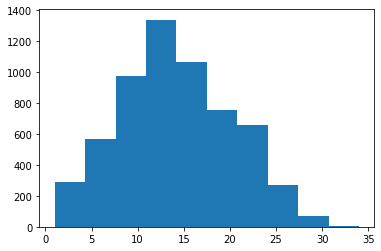

In [28]:
plt.hist(text_lengths)
plt.show()

In [29]:
# add the padding
MAX_LENGTH = 20
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=MAX_LENGTH, padding='post',truncating='post')
test_X =  tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=MAX_LENGTH, padding='post',truncating='post')

In [31]:
train_X[1]

array([   7,   66,   19,  118,    2, 2012,    5,  927,    2,  129,  154,
       1790,   20, 3803, 3804,   28,    2, 1596,    0,    0], dtype=int32)

### Modeling

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout

In [47]:
# create the model
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=MAX_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units=50, go_backwards=True,dropout=0.2, return_sequences=False))
#model.add(LSTM(units=20, go_backwards=False,dropout=0.2))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               26112     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 556,825
Trainable params: 556,825
Non-trainable params: 0
_________________________________________________________________


In [49]:
# compile the model
model.compile(tf.keras.optimizers.Adam(lr = 3e-4),loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# add check points
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',save_best_only=True, save_weights_only=True)
er_stop = EarlyStopping(monitor='val_loss', min_delta=0.001,patience= 5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.001, mode = 'min',
                              patience=2,min_lr = 1e-6)


In [51]:
history = model.fit(train_X, train_y,
          batch_size=16, 
          epochs=50,
          validation_split=0.2, 
          callbacks = [model_checkpoint, er_stop, reduce_lr])

Epoch 1/50
301/301 [==============================] - 11s 26ms/step - loss: 0.6509 - accuracy: 0.6041 - val_loss: 0.4770 - val_accuracy: 0.7877
Epoch 2/50
301/301 [==============================] - 6s 21ms/step - loss: 0.3714 - accuracy: 0.8498 - val_loss: 0.4456 - val_accuracy: 0.8027
Epoch 3/50
301/301 [==============================] - 7s 22ms/step - loss: 0.2697 - accuracy: 0.9014 - val_loss: 0.4958 - val_accuracy: 0.7952
Epoch 4/50
301/301 [==============================] - 6s 22ms/step - loss: 0.2000 - accuracy: 0.9297 - val_loss: 0.5606 - val_accuracy: 0.7860
Epoch 5/50
301/301 [==============================] - 7s 22ms/step - loss: 0.1368 - accuracy: 0.9559 - val_loss: 0.6413 - val_accuracy: 0.7902
Epoch 6/50
301/301 [==============================] - 7s 22ms/step - loss: 0.1250 - accuracy: 0.9590 - val_loss: 0.6960 - val_accuracy: 0.7885
Epoch 7/50
301/301 [==============================] - 6s 21ms/step - loss: 0.1051 - accuracy: 0.9685 - val_loss: 0.7291 - val_accuracy: 0.783

In [52]:
model.evaluate(test_X, test_y)

47/47 [==============================] - 0s 5ms/step - loss: 0.4565 - accuracy: 0.8035


[0.4564518928527832, 0.8034643530845642]

**Confusion matrix**

In [53]:
#prediction
y_hat = model.predict(test_X)

In [54]:
# AUC score
from sklearn.metrics import roc_auc_score
print(f'AUC score: {round(roc_auc_score(test_y, y_hat),3)}')

AUC score: 0.852


In [55]:
from sklearn.metrics import confusion_matrix, classification_report
y_class = np.round(y_hat).astype(int)

In [56]:
conf_mat =confusion_matrix(test_y, y_class)
conf_mat

array([[776,  86],
       [209, 430]])

In [57]:
import seaborn as sns 

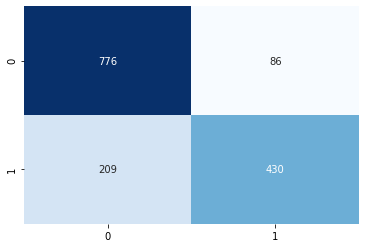

In [58]:
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt= '.3g', cbar=False, )

In [59]:
print(classification_report(test_y, y_class))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       862
           1       0.83      0.67      0.74       639

    accuracy                           0.80      1501
   macro avg       0.81      0.79      0.79      1501
weighted avg       0.81      0.80      0.80      1501

